# Project: Heuristic Policy-Guided RL

In [1]:
from collections import namedtuple
import copy
import gymnasium as gym
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import math
import random
from gym import Env, spaces
from gym.utils import seeding
from gym.envs.registration import register
from enum import IntEnum
from typing import Tuple, Optional, List

## Environments

DQN will be implemented on three environments, based on what was done in EX8

 * Cart Pole: Balance a pole on a moving cart (https://gymnasium.farama.org/environments/classic_control/cart_pole/)
 * Mountain Car: Gather momentum to climb a hill (https://gymnasium.farama.org/environments/classic_control/mountain_car/)
 * Four Rooms: same as in tabular space


In [2]:
# Envs for training (no rendering)
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'mountaincar': gym.make('MountainCar-v0'),
    'acrobot': gym.make('Acrobot-v1'),
}
# Envs for visualization (no build in rendering for 4rooms)
envs_vis = {
    'cartpole': gym.make('CartPole-v1', render_mode="human"),
    'mountaincar': gym.make('MountainCar-v0', render_mode="human"),
    'acrobot': gym.make('Acrobot-v1', render_mode="human"),
}


Environment visualization is set up here:

In [3]:
def render(env, policy=None, repeatNo=0): #I added a repeat number to see a policy repeated multiple times if you want
    """Graphically render an episode using the given policy

    :param env: Gymnasium environment
    :param policy: Function which maps state to action.  If None, the random
                   policy is used.
    """

    if policy is None:
        # Random policy
        def policy(state):
            return env.action_space.sample()
        
    
    repCount = 1

    # Basic gym loop
    state, info = env.reset()
    while True:
        action = policy(state)
        #print(action) #uncomment this to see the actions printed live
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        if terminated or truncated:
            if terminated:
                print("Game ended naturally")
            else:
                print("Episode timed out")
            if repCount < repeatNo:
                state, info = env.reset()
                repCount += 1
            else:
                
                env.close()
                return
        

In [4]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs_vis[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in envs_vis.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


## Part (a): Exponential $\varepsilon$-greedy decay

Instead of using a fixed value of $\varepsilon$, it is common to anneal $\varepsilon$ over time according to a schedule (such that initially almost all actions are exploratory). DQN used a linear decay schedule, but there we will use exponential decay, defined as:
$$\varepsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule. Beyond a specified number of time steps, $\varepsilon$ will be kept fixed at a small constant value to maintain continual exploration.

The interface to the scheduler receives the initial value, the final value, and in how many steps to go from initial to final. Your task is to compute parameters `a` and `b` to make the scheduler work as expected.

In [5]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: Initial value
        :param value_to: Final value
        :param num_steps: Number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE: Determine the `a` and `b` parameters such that the schedule is correct
        self.a = value_from
        self.b = math.log(value_to/self.a)/(num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        Returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step: The step at which to compute the interpolation
        :rtype: Float. The interpolated value
        """

        # YOUR CODE HERE: Implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if step >= self.num_steps-1:
            value = self.value_to
        elif step <= 0:
            value = self.value_from
        else:
            value = self.a * math.exp(self.b * step)
        
        return value


# DO NOT EDIT: Test code

def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )

_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

Here I developed a "difference schedule", i.e. if we want two epsilon parameters where one follows an exponential schedule, the second results in both e1+e2 following a larger exponential schedule.  Thus if the schedules are s1 and s2, e2(t) = s2(t)-s1(t), while e1(t) = s1(t).

This provides an easy way to schedule e1 and e2 such that they never exceed 1.0 and decay accordingly.

In [6]:
class DiffSchedule: #difference schedule- idea is we want to be "e2" in a schedule where e1 + e2 total follows a schedule but 
    #we have to just make up the difference
    def __init__(self, value_from, value_to, num_steps, e1_sched):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: Initial value
        :param value_to: Final value
        :param num_steps: Number of steps for the exponential schedule
        :param e1_sched: an exponential schedule we want to complement
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps
        self.e1_sched = e1_sched

        # YOUR CODE HERE: Determine the `a` and `b` parameters such that the schedule is correct
        self.a = value_from
        self.b = math.log(value_to/self.a)/(num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        Returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step: The step at which to compute the interpolation
        :rtype: Float. The interpolated value
        """

        # Scheduling rule implemented:
        if step >= self.num_steps-1:
            value = self.value_to
        elif step <= 0:
            value = self.value_from
        else:
            value = self.a * math.exp(self.b * step)
            
        #at this point "value" is what we need to reach when added to e1, i.e. our s1, so we do s1-s2 to get e2's value.
        
        e1val = self.e1_sched.value(step)
        
        targ_val = value-e1val
        
        return targ_val
    
# Test code

def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )

_e1sched = ExponentialSchedule(0.1, 0.15, 3)
_e2schedule = DiffSchedule(0.1, 0.2, 3, _e1sched)
_targSchedule = ExponentialSchedule(0.1, 0.2, 3)

print(_e1sched.value(1))
print(_e2schedule.value(1))
print(_e1sched.value(1)+_e2schedule.value(1))
print(_targSchedule.value(1)) #final two prints should be equal
_test_schedule(_e2schedule, 1, 0.141421356237309515-0.1224744871391589)
del _e2schedule
del _e1sched
del _targSchedule



0.1224744871391589
0.018946869098150604
0.1414213562373095
0.1414213562373095


## Part (b): Replay memory

The Replay Memory is the same as in ex8

In [7]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer
            - state_size: Size of the state-space features for the environment
        """
        self.max_size = max_size
        self.state_size = state_size

        # Preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # Pointer to the current location in the circular buffer
        self.idx = 0
        # Indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state: 1-D np.ndarray of state-features
        :param action: Integer action
        :param reward: Float reward
        :param next_state: 1-D np.ndarray of state-features
        :param done: Boolean value indicating the end of an episode
        """

        # YOUR CODE HERE: Store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`

        self.states[self.idx] = torch.from_numpy(state)
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = torch.from_numpy(next_state)
        self.dones[self.idx] = done
        
        # DO NOT EDIT
        # Circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # Update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size: Number of transitions to sample
        :rtype: Batch
        """

        # YOUR CODE HERE: Randomly sample an appropriate number of
        # transitions *without replacement*. If the buffer contains less than
        # `batch_size` transitions, return all of them. The return type must
        # be a `Batch`.

        if batch_size >= self.size:
            sample_indices = list(range(self.size))
        else:
            sample_indices = random.sample(range(self.size),batch_size)
        batch = Batch(self.states[sample_indices], self.actions[sample_indices], self.rewards[sample_indices], \
                      self.next_states[sample_indices], self.dones[sample_indices])

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env: Gymnasium environment
        :param num_steps: Number of steps to populate the replay memory
        """

        # YOUR CODE HERE: Run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        # Hint: Use the self.add() method.
        
        state, _ = env.reset()

        for k in range(num_steps):
            action = env.action_space.sample() #random policy
            next_state, reward, done, truncated, _ = env.step(action)
            
            self.add(state, action, reward, next_state, done)
            
            if done: #or truncated
                state, _ = env.reset()
            else:
                state = next_state
       

## Part (c): Q-network

Q-network definitions are unchanged from ex8

In [8]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # YOUR CODE HERE: Define the layers of your model such that
        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations
        #   (this can be achieved either using a nn.ReLU() object or the nn.functional.relu() method)
        # * the last activation can either be missing, or you can use nn.Identity()
        # Hint: A regular Python list of layers is tempting, but PyTorch does not register
        # these parameters in its computation graph. See nn.ModuleList or nn.Sequential

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(state_dim, hidden_dim)) #first layer, takes from input
        
        for k in range(1, num_layers-1):
            self.layers.append(nn.Linear(hidden_dim,hidden_dim)) #hidden layers
            
        self.layers.append(nn.Linear(hidden_dim,action_dim))
        
    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space. This represents the Q values Q(s, .)
        """
        # YOUR CODE HERE: Use the defined layers and activations to compute
        # the action-values tensor associated with the input states.
        # Hint: Do not worry about the * arguments above (previous dims in tensor).
        # PyTorch functions typically handle those properly.

        x = F.relu(self.layers[0](states))
        
        for layer in self.layers[1:-1]:
            x = F.relu(layer(x))
            
        output = self.layers[-1](x)
        
        return(output)
            
    
    # DO NOT EDIT: Utility methods for cloning and storing models.
    
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


# DO NOT EDIT: Test code

def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )

dqn_model = DQN(10, 4)
_test_dqn_forward(dqn_model, (64, 10), (64, 4))
_test_dqn_forward(dqn_model, (2, 3, 10), (2, 3, 4))
del dqn_model

dqn_model = DQN(64, 16)
_test_dqn_forward(dqn_model, (64, 64), (64, 16))
_test_dqn_forward(dqn_model, (2, 3, 64), (2, 3, 16))
del dqn_model

# Testing custom dump / load
dqn1 = DQN(10, 4, num_layers=10, hidden_dim=20)
dqn2 = DQN.custom_load(dqn1.custom_dump())
assert dqn2.state_dim == 10
assert dqn2.action_dim == 4
assert dqn2.num_layers == 10
assert dqn2.hidden_dim == 20

## Part (d): Single-batch update

unchanged from ex8

In [9]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance
    :param batch: Batch of experiences (class defined earlier)
    :param dqn_model: The DQN model to be trained
    :param dqn_target: The target DQN model, ~NOT~ to be trained
    :param gamma: The discount factor
    :rtype: Float. The scalar loss associated with this batch
    """
    # YOUR CODE HERE: Compute the values and target_values tensors using the
    # given models and the batch of data.
    # Recall that 'Batch' is a named tuple consisting of
    # ('states', 'actions', 'rewards', 'next_states', 'dones')
    # Hint: Remember that we should not pass gradients through the target network
    
    
    values = dqn_model(batch.states).gather(1,batch.actions)
    
    target_values = torch.empty(len(batch.dones), 1)
    
    dqn_target.eval()
    with torch.no_grad():
        for k in range(len(batch.dones)):
            if batch.dones[k] == True:
                target_values[k] = batch.rewards[k]
            else:
                br = batch.rewards[k]
                targQs = dqn_target(batch.next_states[k])
                maxQoverA = torch.max(targQs)
                target_values[k] =  br + gamma*maxQoverA #target is r if terminate, and r + gamma * max over a' of Qhat(phij+1, a', theta-)
                
    
    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # Testing that the values tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor requires gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should not require gradients'

    # Computing the scalar MSE loss between computed values and the TD-target
    # DQN originally used Huber loss, which is less sensitive to outliers
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # Reset all previous gradients
    loss.backward()  # Compute new gradients
    optimizer.step()  # Perform one gradient-descent step

    return loss.item()

## Part (e): DQN training loop

This is the main training loop for DQN. This part is the same as ex8, but there is a version incorporating heuristics right after which is different.

In [10]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes. The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The Gymnasium environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: An ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # Check that environment states are compatible with our DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # Get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # Initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # Initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # Initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # Initialize lists to store returns, lengths, and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # Initialize structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # Use this to indicate the index of the current episode
    t_episode = 0  # Use this to indicate the time-step inside current episode

    state, info = env.reset()  # Initialize state of first episode

    # Iterate for a total of `num_steps` steps
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:
        # Use t_total to indicate the time-step from the beginning of training

        # Save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        with torch.no_grad():
            actionVals = dqn_model(torch.from_numpy(state))
            
            r = random.random()
            eps = exploration.value(t_total)
            if r > eps: #greedy
                (_, action) = torch.max(actionVals, dim=0)
                action = action.item()

            else: #random selection
                action = env.action_space.sample()
            
        next_state, reward, done, truncated, _ = env.step(action)
        
        memory.add(state, action, reward, next_state, done)
        
        
        
        # YOUR CODE HERE: Once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method)
        
        if t_total%4 == 3: #train every 4 steps, not on the first one (so 0,1,2 don't train but 3 does)
            batch = memory.sample(batch_size)
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)

        # YOUR CODE HERE: Once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods)
        
        if t_total%10_000 == 9_999: #once every 10,000 steps, not on the first one
            with torch.no_grad():
                dqn_target.load_state_dict(dqn_model.state_dict()) #load the dqn state dict into the dqn_target
            

        if done or truncated: #commented out because mountain car works better if it has to force its way to end an ep
            # YOUR CODE HERE: Anything you need to do at the end of an episode,
            # e.g., compute return G, store returns/lengths,
            # reset variables, indices, lists, etc.
            
            #normal update
            t_episode += 1
            t_total += 1
            rewards.append(reward)
            
            #calculate G
            G = 0
            for k in range(len(rewards)-1,-1,-1):
                G = gamma*G + rewards[k]
                
            
            #end-of-episode logging data:
            i_episode += 1
            returns.append(G)
            lengths.append(t_episode)

            #given code (I update t_episode above so i removed the +1 from below):
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
        
            #end-of-episode reset:
            t_episode = 0
            rewards = []
            state, info = env.reset()
            
        else:
            # YOUR CODE HERE: Anything you need to do within an episode
            rewards.append(reward)
            t_total += 1
            t_episode += 1
            
            state = next_state #important
            

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

# Training with Heuristics

Here is where the scheduler and heuristics come in.  We now have two parameters- follow_h and exploration, which determine whether the network will follow the given heuristic, explore randomly, or act greedily.  When following the heuristic, it will simply generate an action according to h_pol, which is another new input.

In [11]:
def train_dqn_heuristic(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    follow_h,
    h_pol,
    gamma,
):
    """
    DQN with Heuristics algorithm.

    This will follow a Heuristic policy a certain percentage of the time (defined by a declining epsilon)

    Args:
        - env: The Gymnasium environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: A Schedule for exploration
        - follow_h: A heuristic schedule
        - h_pol: the heuristic policy to use when following the heuristic.  MUST BE TAILORED TO THE ENVIRONMENT
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # Check that environment states are compatible with our DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # Get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # Initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # Initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # Initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # Initialize lists to store returns, lengths, and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # Initialize structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # Use this to indicate the index of the current episode
    t_episode = 0  # Use this to indicate the time-step inside current episode

    state, info = env.reset()  # Initialize state of first episode

    # Iterate for a total of `num_steps` steps
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:
        # Use t_total to indicate the time-step from the beginning of training

        # Save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # THIS IS THE ONLY ALTERED SECTION FROM ABOVE:

        with torch.no_grad():
            actionVals = dqn_model(torch.from_numpy(state))
            
            r = random.random()
            eps = exploration.value(t_total)
            eps2 = follow_h.value(t_total)
            
            if r < eps: #random
                action = env.action_space.sample()
            elif r < eps+eps2: #heuristic
                action = h_pol(state)
                
            else: #greedy
                (_, action) = torch.max(actionVals, dim=0)
                action = action.item()
                
            
        next_state, reward, done, truncated, _ = env.step(action)
        
        memory.add(state, action, reward, next_state, done)
        
        
        
        # YOUR CODE HERE: Once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method)
        
        if t_total%4 == 3: #train every 4 steps, not on the first one (so 0,1,2 don't train but 3 does)
            batch = memory.sample(batch_size)
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)

        # YOUR CODE HERE: Once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods)
        
        if t_total%10_000 == 9_999: #once every 10,000 steps, not on the first one
            with torch.no_grad():
                dqn_target.load_state_dict(dqn_model.state_dict()) #load the dqn state dict into the dqn_target
            

        if done or truncated: #commented out because mountain car works better if it has to force its way to end an ep
            # YOUR CODE HERE: Anything you need to do at the end of an episode,
            # e.g., compute return G, store returns/lengths,
            # reset variables, indices, lists, etc.
            
            #normal update
            t_episode += 1
            t_total += 1
            rewards.append(reward)
            
            #calculate G
            G = 0
            for k in range(len(rewards)-1,-1,-1):
                G = gamma*G + rewards[k]
                
            
            #end-of-episode logging data:
            i_episode += 1
            returns.append(G)
            lengths.append(t_episode)

            #given code (I update t_episode above so i removed the +1 from below):
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode} | Return: {G:5.2f} | e-Explore: {eps:4.2f} | e-Heuristic: {eps2:4.2f}'
            )
        
            #end-of-episode reset:
            t_episode = 0
            rewards = []
            state, info = env.reset()
            
        else:
            # YOUR CODE HERE: Anything you need to do within an episode
            rewards.append(reward)
            t_total += 1
            t_episode += 1
            
            state = next_state #important
            

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

## Heuristics

Here we make heuristic functions for each environment.

The idea is these can be very general, they don't have to be perfect, but they should help guide the agent in a way that lets it learn the best policies faster

For each environment we implement one "good" heuristic, one "mediocre" heuristic, and one "bad" heuristic.  The idea is that the good heuristic is what an intelligent human would advise the agent to do after a somewhat careful look at the environment, the mediocre heuristic is what someone might give as advice after a cursory glance at the environment, and the bad heuristic is what an adversarial agent would tell the agent to do in order to stymie its progress.

In [12]:
#mountain car heuristics
def mc_h_1(state): #good heuristic
    x = state[0]
    vel = state[1]
    if x < -.6: #decently far up the hill to the left to build momentum
        action = 2 #accelerate right
    elif x < .3 and vel < .03: #not far enough up the hill/not enough speed
        action = 0 #accelerate left to gain some height
    else:
        action = 2 #accelerate right
    return action    

def mc_h_2(state): #mediocre heuristic
    x = state[0]
    vel = state[1]
    if x > -.8 and vel < .03: #unless we're moving fast or very far to the left
        action = 0 #accelerate left most of the time
    else:
        action = 2 #in those specific conditions, accelerate right
    return action    

def mc_h_3(state): #bad heuristic
    action = 1 #don't ever accelerate
    
    return action


    

In [13]:
#cart pole heuristics
def cp_h_1(state): #this is the "good" heuristic
    x = state[0] #terminates if it leaves the (-2.4, 2.4) range
    vel = state[1] 
    angle = state[2] #terminates if it leaves the (-.2095, .2095) range
    angleVel = state[3]
    
    if angle < -.05 and x > -2.2: #if the pole is leaning left and we're not about to jump off the edge of the board
        action = 0 #push cart left
    elif angle > .05 and x < 2.2: #if the pole is leaning right and we're not about to jump off the right edge
        action = 1 #push cart right
    elif x >= 2.2: #we're in danger of leaving the map to the right
        action = 0 #push cart left
    elif x <= -2.2: #we're in danger of leaving the map to the left
        action = 1 #push cart right
    else: #pole is relatively balanced and we're not close to the edge of the map, just try and offset angular momentum
        if angleVel < 0: #angle is moving left
            action = 0 #move left to "catch" it
        else: #angle is moving right
            action = 1 #move right to "catch" it
    return action

def cp_h_2(state): #this is the "mediocre" heuristic
    x = state[0] #terminates if it leaves the (-2.4, 2.4) range
    vel = state[1] 
    angle = state[2] #terminates if it leaves the (-.2095, .2095) range
    angleVel = state[3]
    
    if angle < 0: #if the pole is leaning left
        action = 0 #push cart left
    elif angle >= 0: #if the pole is leaning right
        action = 1 #push cart right

    return action

def cp_h_3(state): #adversarial heuristic
    x = state[0] #terminates if it leaves the (-2.4, 2.4) range
    vel = state[1] 
    angle = state[2] #terminates if it leaves the (-.2095, .2095) range
    angleVel = state[3]
    
    if angle < 0: #if the pole is leaning left
        action = 1 #push cart right (makes it fall faster)
    elif angle >= 0: #if the pole is leaning right
        action = 0 #push cart left (makes it fall faster)

    return action

In [ ]:
#Acrobot heuristics

def ab_h_1(state): #good heuristic:
    ct1 = state[0] #cosine of theta 1, between -1 and 1
    st1 = state[1] #sine of theta 1, between -1 and 1
    ct2 = state[2]
    st2 = state[3]
    avt1 = state[4] #angular vel of theta 1, between -4pi to 4pi
    avt2 = state[5] #angular vel of theta 2, between -9pi to 9pi
    
    #policy isn't as obvious here, but generally we want highly neg or highly positive velocities, 
    #and want to "wiggle" until we get those
    
    #it's very possible this "good" hpol will be useless in the end since this environment's dynamics
    #are less obvious
    
    #actions can be:
    #0: apply -1 torque
    #1: apply no torque
    #2: apply +1 torque
    
    if avt1 < -6 and avt2 < -10: #sufficient negative momentum
        action = 0 #keep going in that direction
    elif avt1 > 6 and avt2 > 10: #sufficient positive momentum
        action = 2 #keep going in that direction
    #otherwise we will encourage wiggling behavior- if avt2 is low in magnitude then move in the opposite direction 
    #but if it's high in magnitude then follow it through
    elif -4 < avt2 < 4: #not much momentum so we want to "wiggle" it
        if avt2 > 0:
            action = 0 #go in opposite direction
        elif avt2 < 0:
            action = 2 #go in opposite direction
    else: #larger momentum so we want to build it further by following through
        if avt2 > 0:
            action = 2 #follow through
        elif avt2 < 0:
            action = 0 #follow through
    
    return action
            
def ab_h_2(state): #mediocre heuristic:
    ct1 = state[0] #cosine of theta 1, between -1 and 1
    st1 = state[1] #sine of theta 1, between -1 and 1
    ct2 = state[2]
    st2 = state[3]
    avt1 = state[4] #angular vel of theta 1, between -4pi to 4pi
    avt2 = state[5] #angular vel of theta 2, between -9pi to 9pi
    
    #a very simple policy could just be to keep increasing the magnitude of theta1.  
    #So if it's pointing right we want to push more to the right, and vice versa for the left
    
    #angle to the right -> positive sine, angle to left -> negative sine
    if st1 > 0:
        action = 2
    if st1 < 0:
        action = 0
    
    return action

def ab_h_3(state): #bad heuristic, stay still and don't do anything
    
    action = 1
    return action
    

## Part (f): Evaluation of DQN on the 4 environments

Here we run DQN with heuristics on the four environments, comparing them to other heuristics and heuristic-free progress.

In [15]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### Cart Pole

Testing on the Cart Pole environment, since it should be the easiest one

In [15]:
env = envs['cartpole']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

h_schedule= ExponentialSchedule(.8, 0.001, 1_000_000) #heuristic schedule - early we should follow the heuristic more 
#but it should decay over time
exploration = DiffSchedule(1.0, 0.05, 1_000_000, h_schedule) #our exploration is going to be the difference between
#the heuristic schedule and the total "anything but greedy" schedule - i.e. what used to be the old exploration schedule
#heuristic to follow:
cp_hpol = cp_h_1

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models_h1, returns_h1, lengths_h1, losses_h1 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = cp_hpol,    
    gamma=gamma,
)

assert len(dqn_models_h1) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models_h1.values())

# Saving computed models to disk, so that we can load and visualize them later
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_h1.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

Episode: 17561 | Steps: 63 | Return: 46.91 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:04:56<00:00, 384.99it/s] 


In [21]:
env = envs['cartpole']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

h_schedule= ExponentialSchedule(.8, 0.001, 1_000_000) #heuristic schedule - early we should follow the heuristic more 
#but it should decay over time
exploration = DiffSchedule(1.0, 0.05, 1_000_000, h_schedule) #our exploration is going to be the difference between
#the heuristic schedule and the total "anything but greedy" schedule - i.e. what used to be the old exploration schedule
#heuristic to follow:
cp_hpol_2 = cp_h_2
cp_hpol_3 = cp_h_3

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models_h2, returns_h2, lengths_h2, losses_h2 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = cp_hpol_2,    
    gamma=gamma,
)

dqn_models_h3, returns_h3, lengths_h3, losses_h3 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = cp_hpol_3,    
    gamma=gamma,
)

#we don't bother saving h2 and h3 checkpoints to load later

Episode: 18374 | Steps: 21 | Return: 19.03 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:46:27<00:00, 234.84it/s]     
Episode: 34732 | Steps: 500 | Return: 99.34 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:04:44<00:00, 386.19it/s]


In [16]:
import pickle

#uncomment below to save new objects
# # Saving the objects: 
# with open('objs_cartpole.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([returns_h1, lengths_h1, losses_h1, returns_h2, lengths_h2, losses_h2, returns_h3, lengths_h3, losses_h3], f)

# load data:
with open('objs_cartpole.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    returns_h1, lengths_h1, losses_h1, returns_h2, lengths_h2, losses_h2, returns_h3, lengths_h3, losses_h3 = pickle.load(f)

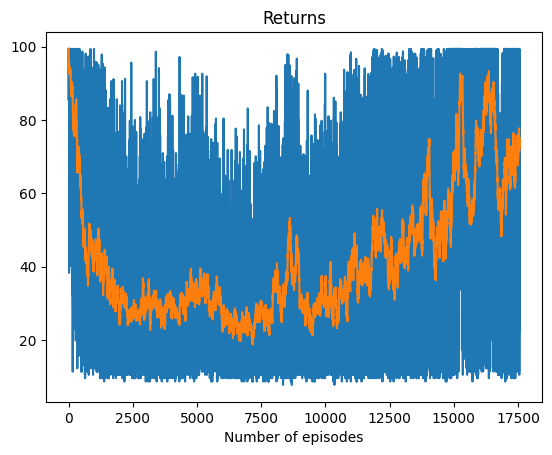

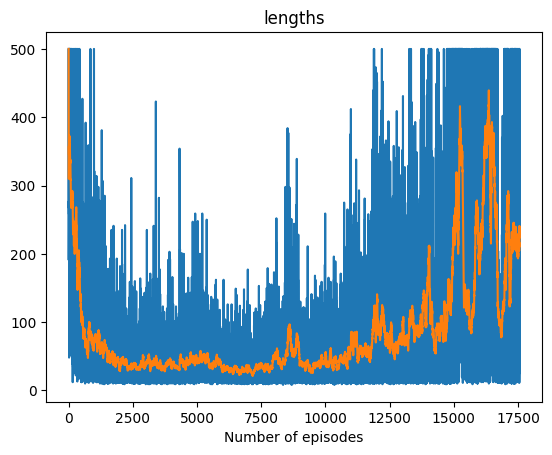

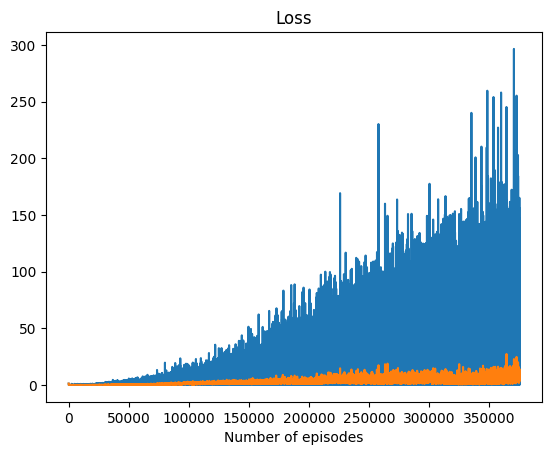

In [17]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_h1)
plt.plot(moving_average(returns_h1))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_h1)
plt.plot(moving_average(lengths_h1))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_h1)
plt.plot(moving_average(losses_h1))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

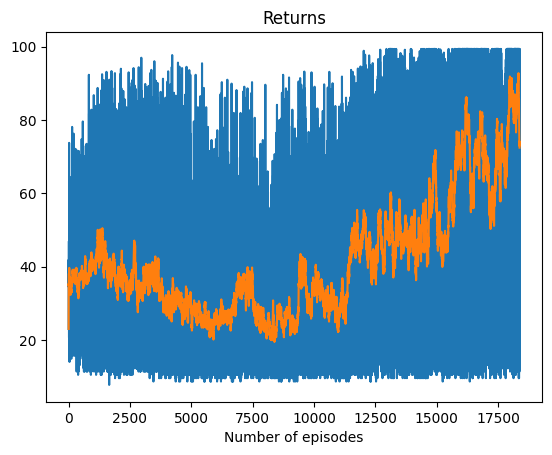

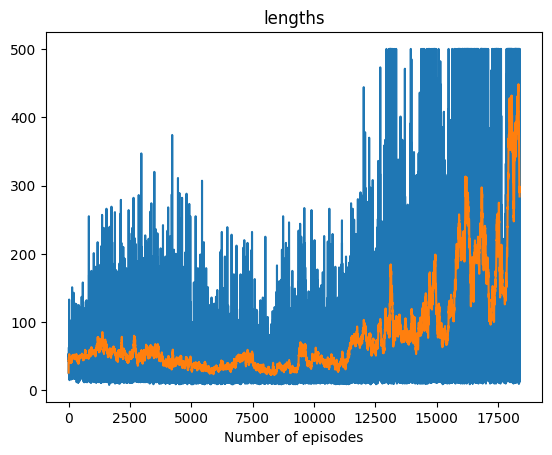

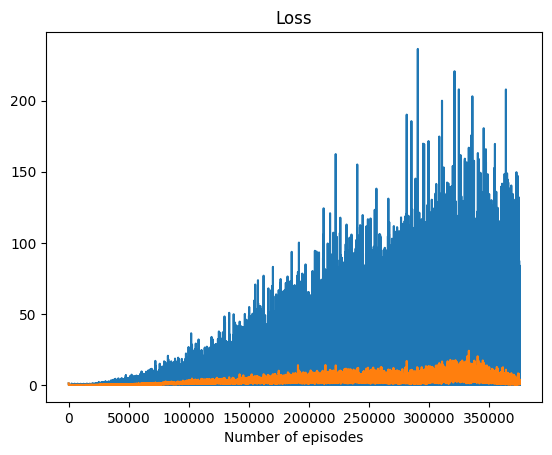

In [23]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_h2)
plt.plot(moving_average(returns_h2))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_h2)
plt.plot(moving_average(lengths_h2))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_h2)
plt.plot(moving_average(losses_h2))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

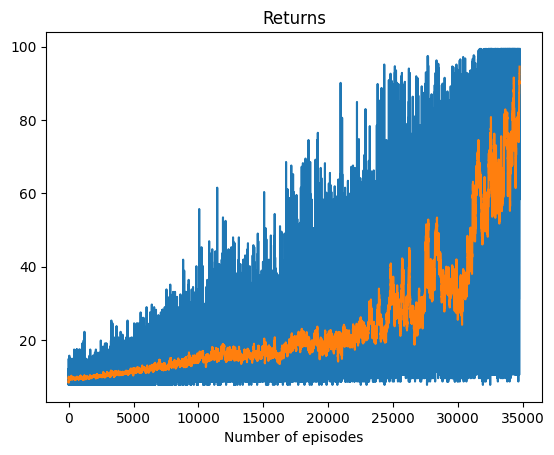

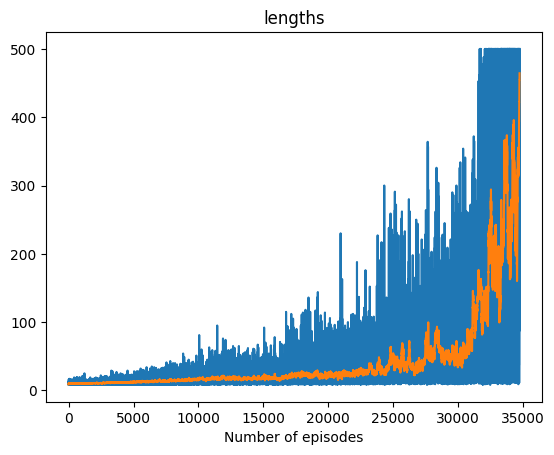

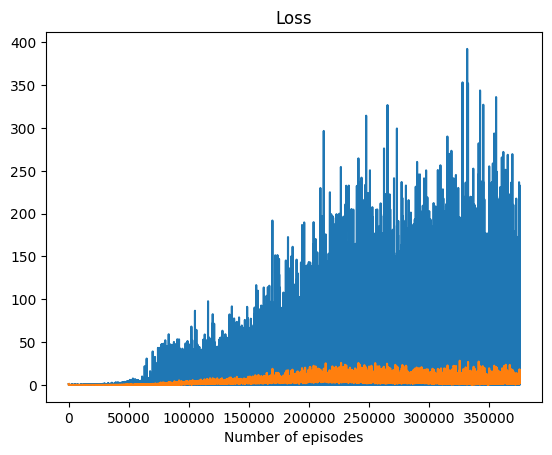

In [24]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_h3)
plt.plot(moving_average(returns_h3))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_h3)
plt.plot(moving_average(lengths_h3))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_h3)
plt.plot(moving_average(losses_h3))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

And for a baseline, Cartpole but without heuristics

In [41]:
env = envs['cartpole']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

exploration= ExponentialSchedule(1.0, 0.05, 1_000_000) #exp schedule

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models_noh, returns_noh, lengths_noh, losses_noh = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,   
    gamma=gamma,
)

assert len(dqn_models_noh) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models_noh.values())

# # Saving computed models to disk, so that we can load and visualize them later
# checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
# torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

Episode: 25314 | Steps: 500 | Return: 99.34 | Epsilon: 0.05: 100%|██████████| 1500000/1500000 [1:09:49<00:00, 358.02it/s]


In [42]:
import pickle

#uncomment below to save new objects
# Saving the objects: 
with open('objs_cartpole.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([returns_h1, lengths_h1, losses_h1, returns_h2, lengths_h2, losses_h2, returns_h3, lengths_h3, losses_h3, returns_noh, lengths_noh, losses_noh], f)

    # load data:
with open('objs_cartpole.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    returns_h1, lengths_h1, losses_h1, returns_h2, lengths_h2, losses_h2, returns_h3, lengths_h3, losses_h3, returns_noh, lengths_noh, losses_noh = pickle.load(f)

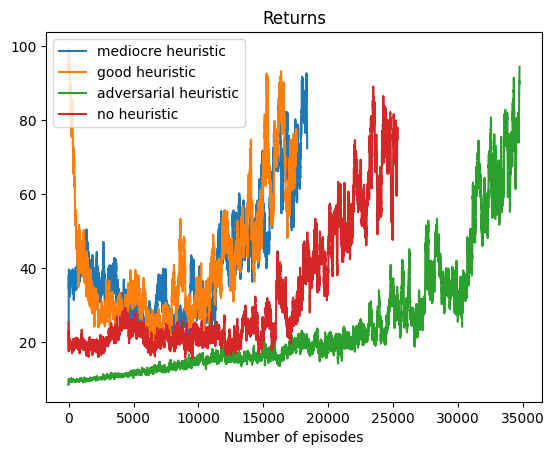

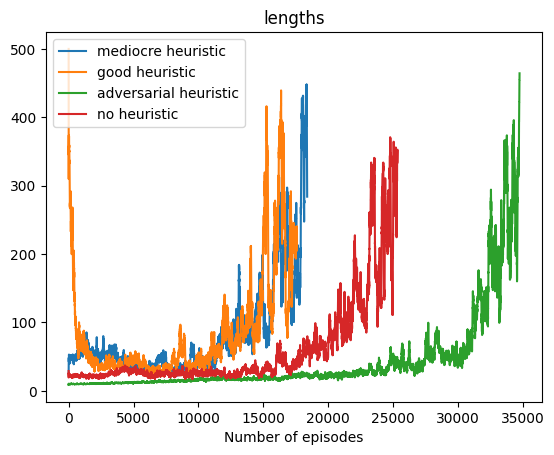

In [43]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(moving_average(returns_h2), label="mediocre heuristic")
plt.plot(moving_average(returns_h1), label="good heuristic")
plt.plot(moving_average(returns_h3), label="adversarial heuristic")
plt.plot(moving_average(returns_noh), label="no heuristic")
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.legend()
plt.show()

plt.figure()
plt.plot(moving_average(lengths_h2), label="mediocre heuristic")
plt.plot(moving_average(lengths_h1), label="good heuristic")
plt.plot(moving_average(lengths_h3), label="adversarial heuristic")
plt.plot(moving_average(lengths_noh), label="no heuristic")
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.legend()
plt.show()

### Mountain Car

Test your implentation on the Mountain Car environment. Training will take much longer than in the previous homeworks, so this time you will not have to find good hyperparameters or train multiple runs. This cell should take about 1-2 hours to run. After training, run the last cell in this notebook to view the policies which were obtained at 0%, 25%, 50%, 75% and 100% of the training

In [33]:
env = envs['mountaincar']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

h_schedule= ExponentialSchedule(.9, 0.001, 1_000_000) #heuristic schedule - early we should follow the heuristic more 
#but it should decay over time
exploration = DiffSchedule(1.0, 0.05, 1_000_000, h_schedule) #our exploration is going to be the difference between
#the heuristic schedule and the total "anything but greedy" schedule - i.e. what used to be the old exploration schedule
#heuristic to follow:
mc_hpol_1 = mc_h_1

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models_mch1, returns_mch1, lengths_mch1, losses_mch1 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = mc_hpol_1,    
    gamma=gamma,
)

assert len(dqn_models_mch1) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models_mch1.values())

# Saving computed models to disk, so that we can load and visualize them later
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_mch1.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

Episode: 9595 | Steps: 109 | Return: -66.56 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:13:44<00:00, 339.01it/s]


In [34]:
env = envs['mountaincar']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

h_schedule= ExponentialSchedule(.9, 0.001, 1_000_000) #heuristic schedule - early we should follow the heuristic more 
#but it should decay over time
exploration = DiffSchedule(1.0, 0.05, 1_000_000, h_schedule) #our exploration is going to be the difference between
#the heuristic schedule and the total "anything but greedy" schedule - i.e. what used to be the old exploration schedule
#heuristic to follow:
mc_hpol_2 = mc_h_2
mc_hpol_3 = mc_h_3

dqn_models_mch2, returns_mch2, lengths_mch2, losses_mch2 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = mc_hpol_2,    
    gamma=gamma,
)

dqn_models_mch3, returns_mch3, lengths_mch3, losses_mch3 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = mc_hpol_3,    
    gamma=gamma,
)

Episode: 7500 | Steps: 200 | Return: -86.60 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:17:28<00:00, 322.67it/s]
Episode: 9184 | Steps: 107 | Return: -65.88 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:24:06<00:00, 297.25it/s] 


In [44]:
env = envs['mountaincar']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

exploration= ExponentialSchedule(1.0, 0.05, 1_000_000) #exp schedule

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models_mcnoh, returns_mcnoh, lengths_mcnoh, losses_mcnoh = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,   
    gamma=gamma,
)

Episode: 7500 | Steps: 200 | Return: -86.60 | Epsilon: 0.05: 100%|██████████| 1500000/1500000 [1:10:08<00:00, 356.39it/s]


In [45]:
import pickle

#uncomment below to save new objects
# Saving the objects: 
with open('objs_mountain_car.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([returns_mch1, lengths_mch1, losses_mch1, returns_mch2, lengths_mch2, losses_mch2, returns_mch3, lengths_mch3, losses_mch3, returns_mcnoh, lengths_mcnoh, losses_mcnoh], f)

# load data:
with open('objs_mountain_car.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    returns_mch1, lengths_mch1, losses_mch1, returns_mch2, lengths_mch2, losses_mch2, returns_mch3, lengths_mch3, losses_mch3, returns_mcnoh, lengths_mcnoh, losses_mcnoh = pickle.load(f)

#### Plot the returns, lengths, and losses obtained while running DQN on the Mountain Car environment.

Again we compare heuristics to each other

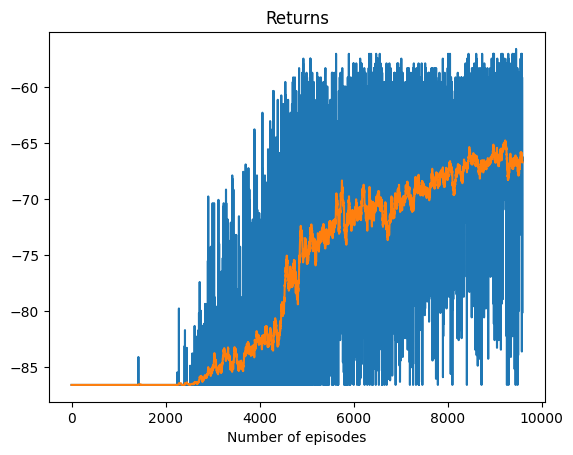

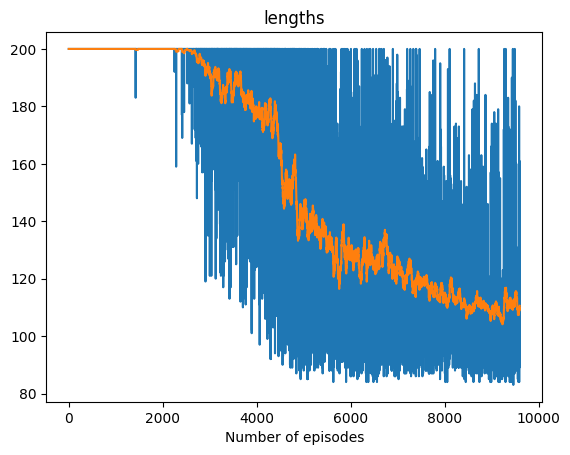

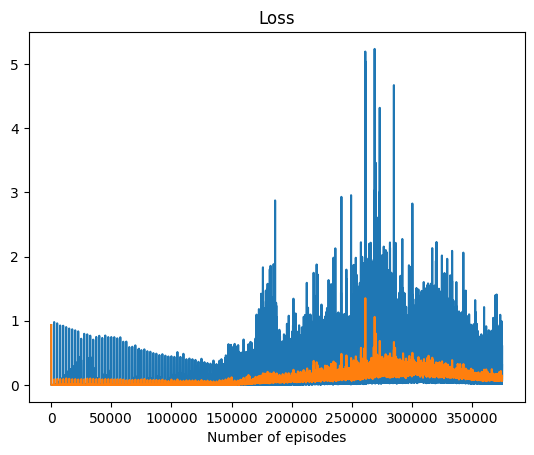

In [37]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_mch1)
plt.plot(moving_average(returns_mch1))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_mch1)
plt.plot(moving_average(lengths_mch1))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_mch1)
plt.plot(moving_average(losses_mch1))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

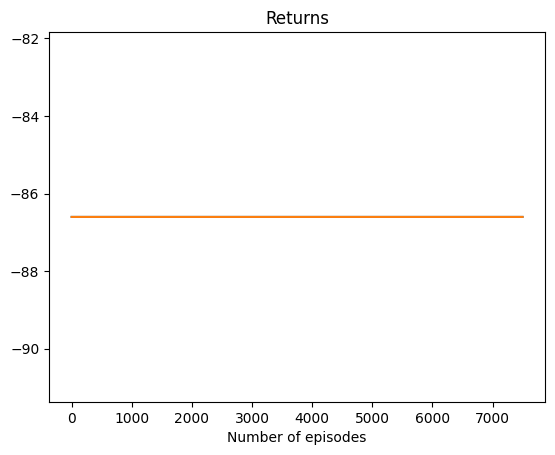

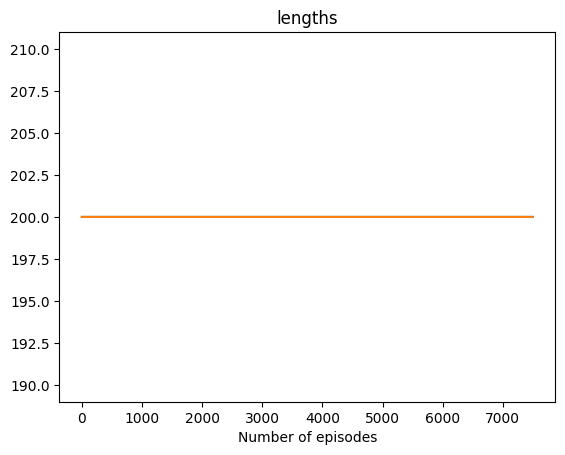

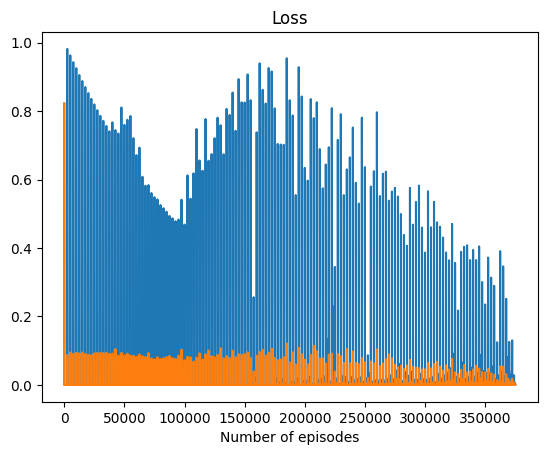

In [38]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_mch2)
plt.plot(moving_average(returns_mch2))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_mch2)
plt.plot(moving_average(lengths_mch2))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_mch2)
plt.plot(moving_average(losses_mch2))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

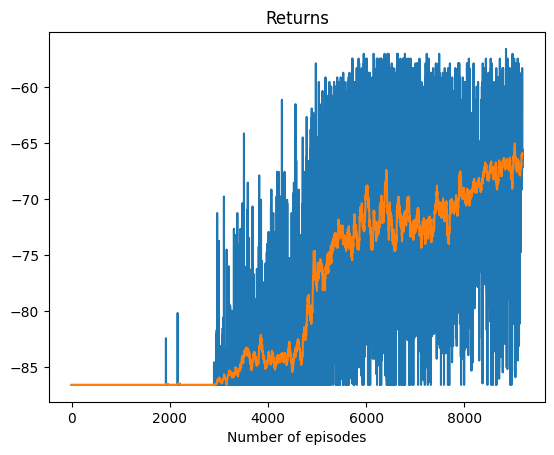

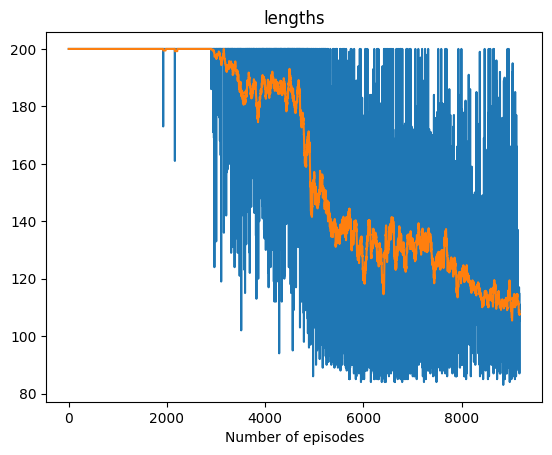

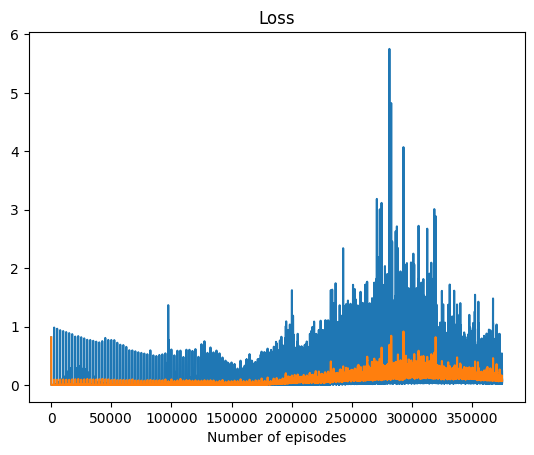

In [39]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_mch3)
plt.plot(moving_average(returns_mch3))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_mch3)
plt.plot(moving_average(lengths_mch3))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_mch3)
plt.plot(moving_average(losses_mch3))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

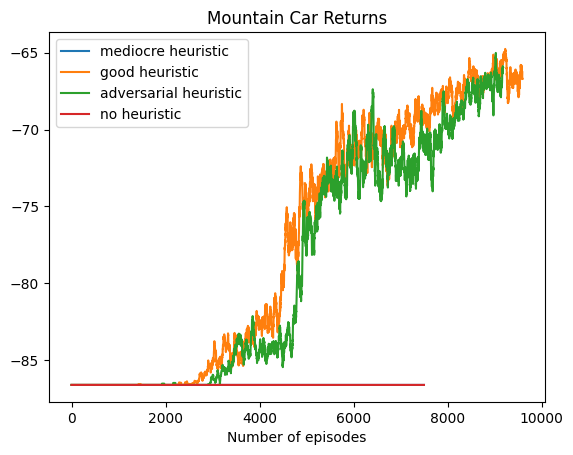

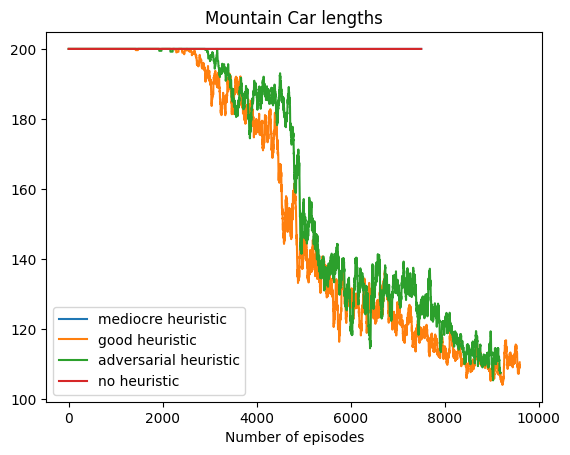

In [46]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(moving_average(returns_mch2), label="mediocre heuristic")
plt.plot(moving_average(returns_mch1), label="good heuristic")
plt.plot(moving_average(returns_mch3), label="adversarial heuristic")
plt.plot(moving_average(returns_mcnoh), label="no heuristic")
plt.title("Mountain Car Returns")
plt.xlabel("Number of episodes")
plt.legend()
plt.show()

plt.figure()
plt.plot(moving_average(lengths_mch2), label="mediocre heuristic")
plt.plot(moving_average(lengths_mch1), label="good heuristic")
plt.plot(moving_average(lengths_mch3), label="adversarial heuristic")
plt.plot(moving_average(lengths_mcnoh), label="no heuristic")
plt.title("Mountain Car lengths")
plt.xlabel("Number of episodes")
plt.legend()
plt.show()

# Acrobot
Testing on the acrobot environment

In [71]:
env = envs['acrobot']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

h_schedule= ExponentialSchedule(.8, 0.001, 1_000_000) #heuristic schedule - early we should follow the heuristic more 
#but it should decay over time
exploration = DiffSchedule(1.0, 0.05, 1_000_000, h_schedule) #our exploration is going to be the difference between
#the heuristic schedule and the total "anything but greedy" schedule - i.e. what used to be the old exploration schedule
#heuristic to follow:
ab_hpol = ab_h_1

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models_abh1, returns_abh1, lengths_abh1, losses_abh1 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = ab_hpol,    
    gamma=gamma,
)

assert len(dqn_models_abh1) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models_abh1.values())

Episode: 12504 | Steps: 65 | Return: -47.44 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:08:02<00:00, 367.38it/s] 


In [72]:
env = envs['acrobot']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

h_schedule= ExponentialSchedule(.8, 0.001, 1_000_000) #heuristic schedule - early we should follow the heuristic more 
#but it should decay over time
exploration = DiffSchedule(1.0, 0.05, 1_000_000, h_schedule) #our exploration is going to be the difference between
#the heuristic schedule and the total "anything but greedy" schedule - i.e. what used to be the old exploration schedule
#heuristic to follow:
ab_hpol_2 = ab_h_2
ab_hpol_3 = ab_h_3

dqn_models_abh2, returns_abh2, lengths_abh2, losses_abh2 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = ab_hpol_2,    
    gamma=gamma,
)

dqn_models_abh3, returns_abh3, lengths_abh3, losses_abh3 = train_dqn_heuristic(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    follow_h = h_schedule,
    h_pol = ab_hpol_3,    
    gamma=gamma,
)

Episode: 13242 | Steps: 71 | Return: -50.52 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:11:52<00:00, 347.81it/s] 
Episode: 11812 | Steps: 76 | Return: -52.94 | e-Explore: 0.05 | e-Heuristic: 0.00: 100%|██████████| 1500000/1500000 [1:07:50<00:00, 368.50it/s] 


In [47]:
env = envs['acrobot']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64

exploration= ExponentialSchedule(1.0, 0.05, 1_000_000) #exp schedule

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models_abnoh, returns_abnoh, lengths_abnoh, losses_abnoh = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,   
    gamma=gamma,
)

Episode: 12666 | Steps: 65 | Return: -47.44 | Epsilon: 0.05: 100%|██████████| 1500000/1500000 [1:10:09<00:00, 356.33it/s] 


In [48]:
import pickle

#uncomment below to save new objects
# Saving the objects: 
with open('objs_acrobot.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([returns_abh1, lengths_abh1, losses_abh1, returns_abh2, lengths_abh2, losses_abh2, returns_abh3, lengths_abh3, losses_abh3, returns_abnoh, lengths_abnoh, losses_abnoh], f)

# load data:
with open('objs_acrobot.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    returns_abh1, lengths_abh1, losses_abh1, returns_abh2, lengths_abh2, losses_abh2, returns_abh3, lengths_abh3, losses_abh3, returns_abnoh, lengths_abnoh, losses_abnoh = pickle.load(f)

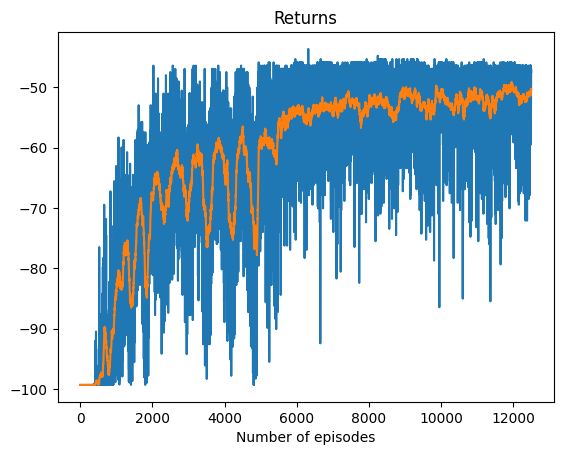

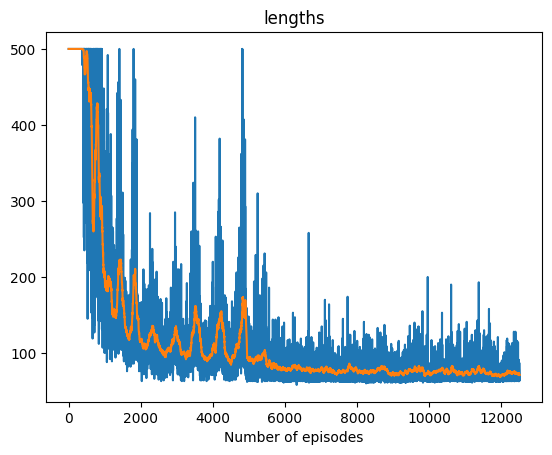

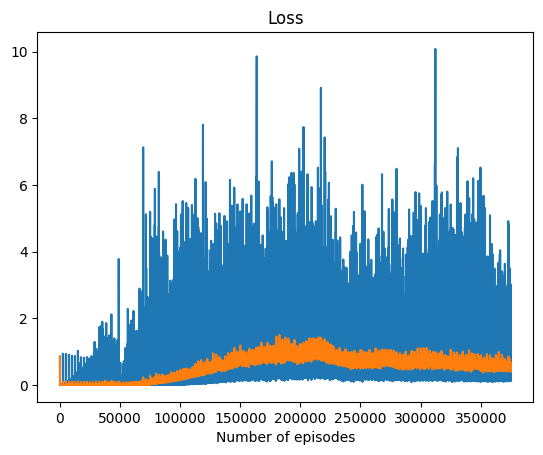

In [28]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_abh1)
plt.plot(moving_average(returns_abh1))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_abh1)
plt.plot(moving_average(lengths_abh1))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_abh1)
plt.plot(moving_average(losses_abh1))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

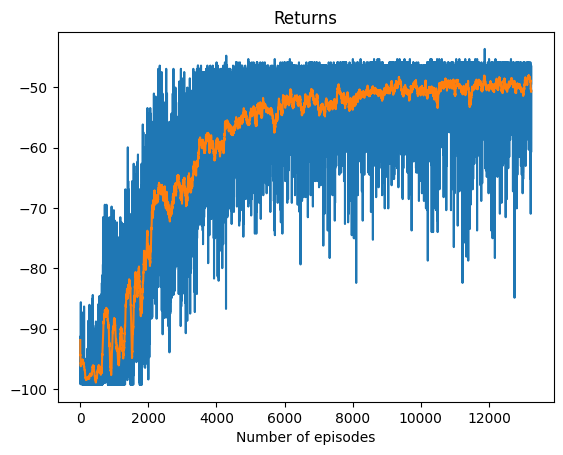

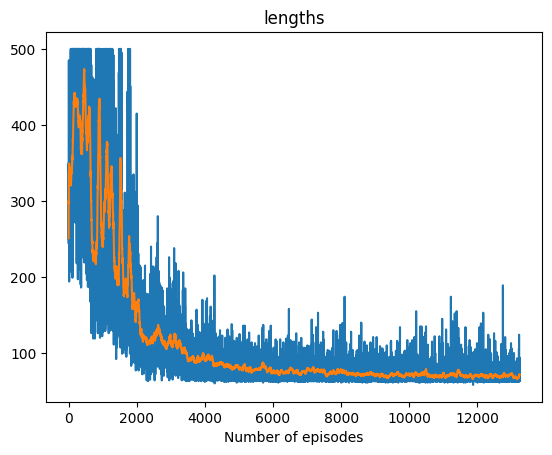

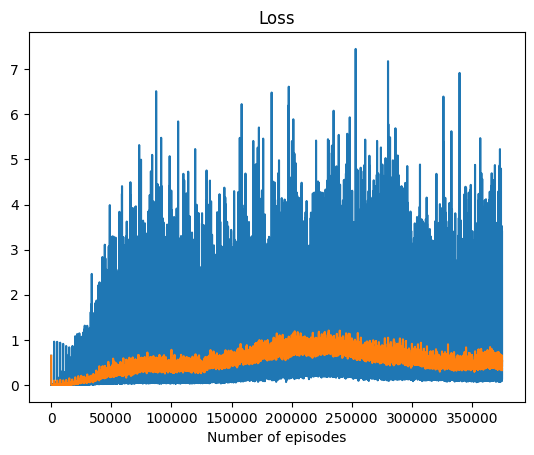

In [29]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_abh2)
plt.plot(moving_average(returns_abh2))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_abh2)
plt.plot(moving_average(lengths_abh2))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_abh2)
plt.plot(moving_average(losses_abh2))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

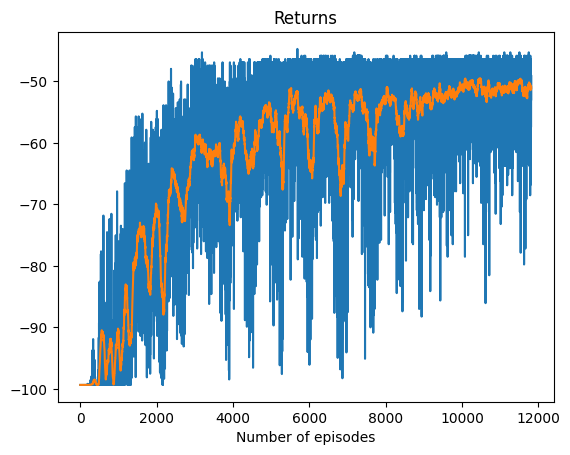

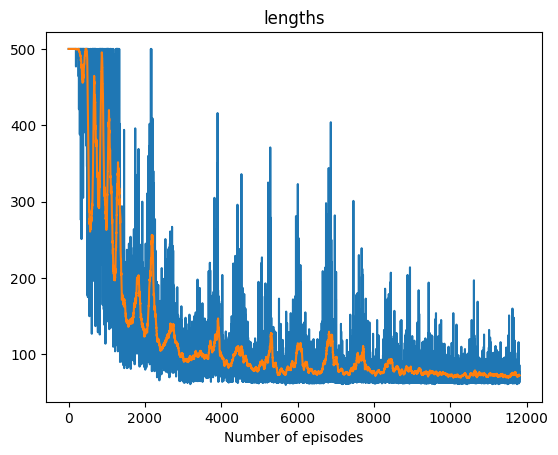

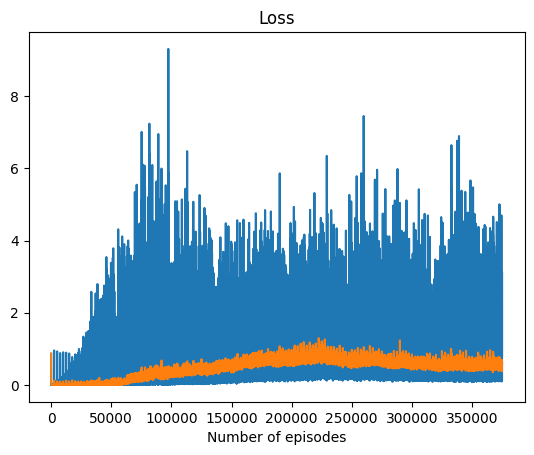

In [30]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(returns_abh3)
plt.plot(moving_average(returns_abh3))
plt.title("Returns")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(lengths_abh3)
plt.plot(moving_average(lengths_abh3))
plt.title("lengths")
plt.xlabel("Number of episodes")
plt.show()

plt.figure()
plt.plot(losses_abh3)
plt.plot(moving_average(losses_abh3))
plt.title("Loss")
plt.xlabel("Number of episodes")
plt.show()

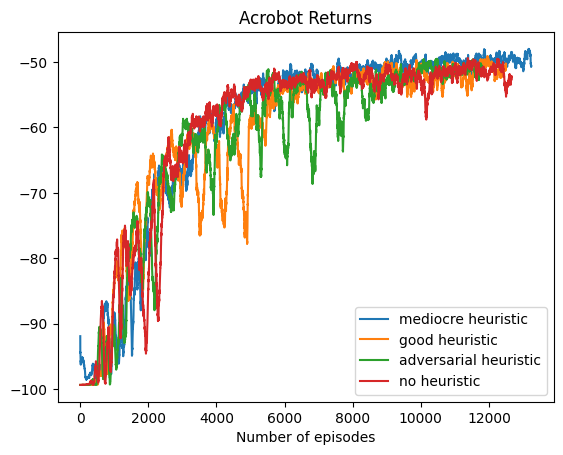

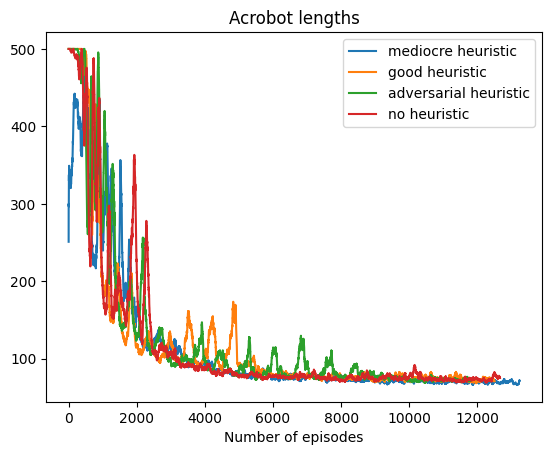

In [49]:
# YOUR PLOTTING CODE HERE
plt.figure()
plt.plot(moving_average(returns_abh2), label="mediocre heuristic")
plt.plot(moving_average(returns_abh1), label="good heuristic")
plt.plot(moving_average(returns_abh3), label="adversarial heuristic")
plt.plot(moving_average(returns_abnoh), label="no heuristic")
plt.title("Acrobot Returns")
plt.xlabel("Number of episodes")
plt.legend()
plt.show()

plt.figure()
plt.plot(moving_average(lengths_abh2), label="mediocre heuristic")
plt.plot(moving_average(lengths_abh1), label="good heuristic")
plt.plot(moving_average(lengths_abh3), label="adversarial heuristic")
plt.plot(moving_average(lengths_abnoh), label="no heuristic")
plt.title("Acrobot lengths")
plt.xlabel("Number of episodes")
plt.legend()
plt.show()

### Visualization of the trained policies

Run the cell below and push the buttons to view the progress of the policy trained using DQN.

In [142]:
#note: the code as-given kept crashing at the end of episodes, so I edited the Render() code a bit to close the environment
#after a few episodes.  Once you've visualized a policy you have to rerun the first few cells and then this one in a 
#new kernel.

buttons_all = []
for key_env, env in envs_vis.items():
    try:
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)
            
            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True
                        
                    #added a repeat # to the next line to visualize the policies more
                    render(env, lambda state: dqn(torch.tensor(state, dtype=torch.float)).argmax().item(), repeatNo = 5)
                    
                    for b in buttons_all:
                        b.disabled = False
                        
                return button_callback
                
            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)
        
        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)

cartpole:


mountaincar:


Episode timed out
Game ended naturally
Episode timed out
Game ended naturally
Episode timed out


### Analysis

For each environment that you trained in, describe the progress of the training in terms of the behavior of the agent at each of the 5 phases of training (i.e. 0%, 25%, 50%, 75%, 100%). Make sure you view each phase a few times so that you can see all sorts of variations.

Describe something for each phase. Start by describing the behavior at phase 0%, then, for each next phase, describe how it differs from the previous one, how it improves and/or how it becomes worse. At the final phase (100%), also describe the observed behavior in absolute terms, and whether it has achieved optimality.

*Note: You may need to restart the kernel after rendering some episodes. Do not manually close the Pygame window. Even if you restart the kernel, you do not need to re-train on the environments; the relevant Q-network parameters should be stored in the corresponding PyTorch checkpoint .pt file.*

#### Cart Pole

* 0%) It seems to wobble randomly, very often letting the pole fall off the cart and ending the episodes.  Looking at the printed actions, there's a lot of randomly mixed 0s and 1s.
* 25%) Even as early as this, it's doing a decent job of keeping the pole balanced.  Episodes tend to end by moving the cart off the side of the screen, but in terms of balancing it's already doing an ok job.
* 50%) It seems to have picked up a strong preference for the left side of the field, and at this point actually was doing a little worse than the 25% policy.  It had the angle-balancing down but ran off-map pretty often.  
* 75%) This one seems to favor going to the right- perhaps it's overcorrected from the 50% policy?  A lot of the same issues arise- it does ok with actually balancing the pole but goes off-screen a lot.  It also goes to the right very quickly, whereas a more measured approach would probably be better.
* 100%) At this point it travels more cautiously to the right, and then "jitters" for a while- intentionally keeping the pole well balanced and achieving long episodes.  In my case all 5 episodes timed out instead of actually termiating due to losing balance or going off the map, which appears to be optimal to me.

#### Mountain Car

* 0%) It seeming randomly wobbled in the middle of the valley, making no progress on either hill.  This makes sense, as it hasn't learned any behavior yet and will act essentially randomly.
* 25%) Even at 25%, it stays very still in the center of the valley.  It goes back and forth a little bit, but moves possibly even less than at 0% training.  It still hasn't learned any useful information about the environment, and every episode times out instead of actually finishing.
* 50%) At this point it's started to learn some "rocking" behavior, i.e. traveling back to get some momentum and then traveling further forward.  I suspect it's learned a lot of negative values for the central valley area and is trying to escape beyond that, but hasn't quite figured out how to do so yet.
* 75%) It almost feels like it's lost the progress from 50%- most of the time it stays very still.  Two of the five repetitions did show some significant "rocking" behavior, but for the other three it stood very still in the middle of the valley.  The program is still doing rather poorly.
* 100%) At this point it's finally learning to use the left-side hill to gain momentum.  It's still far from perfect/optimal, as three of the five attempts timed out instead of ending by reaching the goal, but all five were attempting to build up momentum on the leftward hill before climbing the hill on the right.  I expect it'd take nearly double as long in training to even consistently end the game before the 200 step timeout, nevermind optimality.  This is a much harder learning environment than cart-pole

#### Acrobot ###Didn't have the time to run on this environment###

* 0%) YOUR ANSWER HERE.
* 25%) YOUR ANSWER HERE.
* 50%) YOUR ANSWER HERE.
* 75%) YOUR ANSWER HERE.
* 100%) YOUR ANSWER HERE.

#### Lunar Lander ###box2d issues made this one not work for me###

* 0%) YOUR ANSWER HERE.
* 25%) YOUR ANSWER HERE.
* 50%) YOUR ANSWER HERE.
* 75%) YOUR ANSWER HERE.
* 100%) YOUR ANSWER HERE.

## [Extra credit.] Part (g): DQN extensions

We briefly gave an overview of several extensions to DQN, described in the "Rainbow" paper:\
Rainbow: Combining improvements in deep reinforcement learning\
Matteo Hessel, Joseph Modayil, Hado van Hasselt, Tom Schaul, Georg Ostrovski, Will Dabney, Dan Horgan, Bilal Piot, Mohammad Azar, David Silver\
AAAI Conference on Artificial Intelligence, 2018\
https://aaai.org/papers/11796-rainbow-combining-improvements-in-deep-reinforcement-learning/

Read about these extensions in the Rainbow paper and their corresponding source paper(s). Implement one or more of these extensions from scratch and evaluate them on at least 2 of the environments above. Compare against the original DQN and discuss your findings.